<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Scraping_nettoyage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chargement des packages utiles

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np

## Aperçu de la base initiale

La base que nous avons décidé de choisir pour mener à bien notre projet est un ensemble de données collecté par TMDB (The Movie Database, une API), ainsi que GroupLens, un laboratoire de recherche de l'université du Minnesota.

Le dataset est disponible à l'adresse suivante : https://www.kaggle.com/rounakbanik/the-movies-dataset.

Ces données regroupent plus de 45 000 films et donnent de nombreuses caractéristiques, tels que le genre, le budget et le revenu généré par le film. Une partie de la base a été prénettoyée sur Excel et avec des méthodes Python simples. 

In [ ]:
# On crée un dossier temporaire pour dézipper le csv
import tempfile

temp_dir = tempfile.mkdtemp()


In [ ]:
# Pour dezipper le csv disponible dans le git (movies metadata)

import zipfile

with zipfile.ZipFile('movies_metadata.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')
    

In [ ]:
df = pd.read_csv(r'temp_dir/movies_metadata.csv', sep=',', low_memory = False)

# Généralités sur la base

On regarde : 
- quelles colonnes sont les mieux renseignées
- quelles colonnes il faut supprimer
- si les types de chaque variable est cohérent

#### Sommaire 
1. Nettoyage des colonnes
2. Nettoyage sur les lignes
3. Nettoyage variable par variable
    - *popularity*
    - *vote_average* et *vote_count*
    - *production_companies* et *production_countries*

## Nettoyage des colonnes

Complétude totale en pourcentage de la base : 90.32592120119062 %


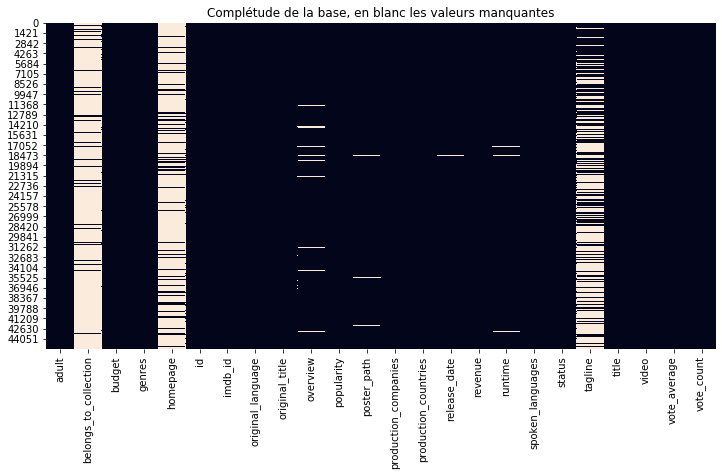

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Complétude de la base, en blanc les valeurs manquantes')
print("Complétude totale en pourcentage de la base :", (1-df.isnull().sum().sum()/(len(df.id)*len(df.columns)))*100,'%')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Notre base de données est très volumineuse. Or toutes les colonnes ne nous seront pas utiles pour notre analyse. Par conséquent, pour une question de mémoire nous avons décidé de les supprimer. 

En particulier, les informations données dans la colonne *spoken_languages* étant peu claires, nous préférons enlever cette colonne de notre dataset.
Les informations *taglines*, *homepage* et *belongs_to_collection* ne sont pas très bien renseignées ni forcément pertinentes, on va donc les dropper de même. En revanche, avant de dropper *belongs_to_collection*, on va créer une variable binaire renseignant si oui ou non un film appartient à une collection (c'est-à-dire correspond à un volet de plusieurs films) puisqu'il s'agit d'une information pouvant avoir une importance significative sur le succès du film. 

Tous les types sont des *object* à l'exception des variables *revenue*, *runtime*, *vote_average*, et *vote_count*. On s'attend toutefois à avoir pour *popularity* qui est un score de popularité ainsi que pour *budget* des formats *float64* ou *int*. Il faudra se pencher sur ces variables. 

In [ ]:
df.belongs_to_collection

0        {'id': 10194, 'name': 'Toy Story Collection', ...
1                                                      NaN
2        {'id': 119050, 'name': 'Grumpy Old Men Collect...
3                                                      NaN
4        {'id': 96871, 'name': 'Father of the Bride Col...
                               ...                        
45461                                                  NaN
45462                                                  NaN
45463                                                  NaN
45464                                                  NaN
45465                                                  NaN
Name: belongs_to_collection, Length: 45466, dtype: object

In [ ]:
df.belongs_to_collection = df.belongs_to_collection.fillna(0)

*collection* prend la valeur 1 si le film appartient à une collection, 0 sinon. 

In [ ]:
df['collection']= np.where(df['belongs_to_collection']!= 0, 1, 0)

In [ ]:
df.collection.head()

0    1
1    0
2    1
3    0
4    1
Name: collection, dtype: int64

In [ ]:
df = df.drop(columns ='spoken_languages')
df = df.drop(columns ='tagline')
df = df.drop(columns ='homepage')
df = df.drop(columns ='belongs_to_collection')

In [ ]:
df.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'status', 'title', 'video', 'vote_average',
       'vote_count', 'collection'],
      dtype='object')

On va s'intéresser rapidement aux types de chaque variable et en tirer leur pertinence ou non pour notre étude. 

In [ ]:
pd.unique(df.adult)

array(['False', 'True', ' - Written by Ørnås',
       ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.',
       ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.'],
      dtype=object)

Vraisemblablement, *adult* est une variable binaire prenant la valeur *True* lorsqu'un film est un film pour adulte, *False* lorsque c'est un film tout public. On remarque qu'il y a des erreurs de collecte lors du scrapping mais cette variable n'étant pas très intéressante pour nous, nous allons la dropper. 

In [ ]:
df.head(1)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,revenue,runtime,status,title,video,vote_average,vote_count,collection
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,Released,Toy Story,False,7.7,5415.0,1


In [ ]:
print('Modalités status :', pd.unique(df.status))
print('Modalités video :', pd.unique(df.video))

Modalités status : ['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']
Modalités video : [False True nan]


On n'utilisera pas les images à priori. On peut enlever *poster_path*. Les modalités de *video* ne sont pas très intéressantes non plus. 

In [ ]:
df = df.drop(columns ='video')
df = df.drop(columns ='poster_path')
df = df.drop(columns ='adult')

## Nettoyage sur les lignes

Nous n'avons pas vérifié encore la cohérence sur les lignes du dataset. Vérifions d'abord que le dataset ne contient que des *id* uniques. Sinon, on retire les informations en surplus. 

In [ ]:
print("Doublons d'id : " , len(df)-len(pd.unique(df.id)))
print("Doublons d'id imdb : " , len(df)-len(pd.unique(df.imdb_id)))
df = df.drop_duplicates(subset=['id'])
df = df.drop_duplicates(subset=['imdb_id'])

Doublons d'id :  30
Doublons d'id imdb :  48


   Les lignes ayant été nettoyées, les colonnes une première fois aussi, on va mettre *id* en index du dataframe. 

In [ ]:
df = df.set_index('id')

## Nettoyage par variable

### *Popularity*
Sur *The Movie Database* un indicateur de popularité a été construit à la date *t* en prenant en compte les informations suivantes d'après la documentation :
- Nombre de votes
- Nombre de vues 
- Nombre de favoris 
- Nombre de gens ayant le film dans leur "watchlist"
- Date de sortie
- Nombre de votes totaux
- Score des jours précédents

Néanmoins, les détails de la métrique ne sont pas explicités. 

In [ ]:
df.popularity = df.popularity.astype('float64')
df.popularity.describe()

count    45414.000000
mean         2.921932
std          6.007588
min          0.000000
25%          0.386107
50%          1.127685
75%          3.679143
max        547.488298
Name: popularity, dtype: float64

In [ ]:
df.popularity.describe()

count    45414.000000
mean         2.921932
std          6.007588
min          0.000000
25%          0.386107
50%          1.127685
75%          3.679143
max        547.488298
Name: popularity, dtype: float64

Observons les 20 meilleurs films par popularité : 

In [ ]:
df.sort_values(by='popularity', ascending=False)['original_title'].head(20)

id
211672                                             Minions
297762                                        Wonder Woman
321612                                Beauty and the Beast
339403                                         Baby Driver
177572                                          Big Hero 6
293660                                            Deadpool
283995                      Guardians of the Galaxy Vol. 2
19995                                               Avatar
245891                                           John Wick
210577                                           Gone Girl
131631               The Hunger Games: Mockingjay - Part 1
281338                      War for the Planet of the Apes
271110                          Captain America: Civil War
680                                           Pulp Fiction
166426    Pirates of the Caribbean: Dead Men Tell No Tales
155                                        The Dark Knight
78                                            Blade R

Cela paraît à peu près cohérent, il s'agit bien de films connus. 

Popularity est complet à  99.99119291910696 %


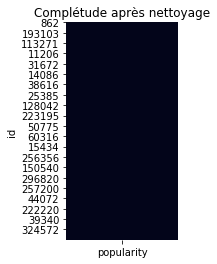

In [ ]:
fig, ax = plt.subplots(figsize=(2,4))
sns.heatmap(df[['popularity']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Popularity est complet à ',(1-len(df.popularity[df.popularity.isnull()])/len(df.popularity))*100,'%')

### *vote_average* et *vote_count*
*vote_average* : variable renseignée sur *TMDb*, elle donne la moyenne des votes sur tMDb sur 10. 

*vote_count* : variable de *TMDb* donnant le nombre de votant pour chaque film. 

In [ ]:
print('statistiques: \n ',df.vote_average.describe())

print('nombre de nan: \n', df.vote_average.isnull().sum())

statistiques: 
  count    45414.000000
mean         5.618864
std          1.923210
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64
nombre de nan: 
 4


 Notons que le pic à 0 est dû à un certain nombre de films non notés. Il n'y a seulement 4 NaNs, par défaut, le site met une moyenne de votes nuls si le nombre de votant est nul. 

Text(0.5, 1.0, 'Distribution des notes moyennes sur imdb')

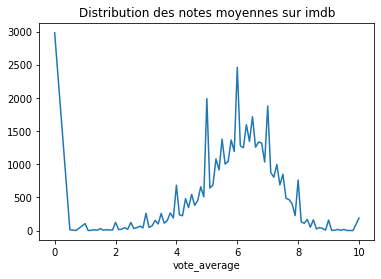

In [ ]:
df.groupby(df['vote_average']).imdb_id.count().plot()
plt.title('Distribution des notes moyennes sur imdb')

In [ ]:
df.sort_values(by='vote_average', ascending=False)['original_title'].head(20)

id
433945                                 東京喰種 トーキョーグール
162611    Portrait of a Young Man in Three Movements
81616                             Im Alter von Ellen
278939                          Girl in the Cadillac
279979          The Court-Martial of Jackie Robinson
132812                               Cowboy del Amor
206657                                 Truckfighters
367966    Harold and Lillian: A Hollywood Love Story
347328                      אני לא מאמין, אני רובוט!
288503                                       Killjoy
43823                        Tom Brown's School Days
177869                           Survive and Advance
218974                                    Redemption
143750                             The Farmer's Wife
403593                                       Bazodee
185273                              Bowery Battalion
64562                       Other Voices Other Rooms
150658                                Goodbye & Amen
243934                                     

En se basant sur les moyennes des notes seules on observe sans surprise un résultat très différent pour la liste des 20 meilleurs films puisque ces moyennes ne prennent pas en compte le poids du nombre de votes. Dans la liste, il s'agit surtout de films inconnus du grand public. 

In [ ]:
print('statistiques: \n',df.vote_count.describe())
print('valeurs manquantes: \n', df.vote_count.isnull().sum())

statistiques: 
 count    45414.000000
mean       109.971837
std        491.549122
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64
valeurs manquantes: 
 4


### Quelques métriques supplémentaires 
On peut essayer d'établir une métrique permettant d'améliorer l'observation du succès d'un film basé sur sa note.

    score_1 = vote_count × vote_average
    score_2 = vote_count × vote_average²
    score_3 = vote_count² × vote_average


In [ ]:
df['score_1'] = df.vote_count.mul(df.vote_average)
df['score_2'] = df.vote_count.mul(df.vote_average.pow(2))
df['score_3'] = df.vote_count.pow(2).mul(df.vote_average)

In [ ]:
l_score1 = df.sort_values(by='score_1', ascending=False)['original_title'].head(20).tolist()
l_score2 = df.sort_values(by='score_2', ascending=False)['original_title'].head(20).tolist()
l_score3 = df.sort_values(by='score_3', ascending=False)['original_title'].head(20).tolist()

pd.DataFrame({'score_1': l_score1 ,'score_2' : l_score2, 'score_3' : l_score3})

,score_1,score_2,score_3
0,Inception,Inception,Inception
1,The Dark Knight,The Dark Knight,The Dark Knight
2,Interstellar,Interstellar,The Avengers
3,The Avengers,Fight Club,Avatar
4,Avatar,The Avengers,Interstellar
5,Deadpool,Avatar,Deadpool
6,Fight Club,Deadpool,Django Unchained
7,Django Unchained,Django Unchained,Guardians of the Galaxy
8,Guardians of the Galaxy,Guardians of the Galaxy,Fight Club
9,Pulp Fiction,The Shawshank Redemption,Mad Max: Fury Road


La première métrique obtenue a un résultat correspondant davantage à l'idée que l'on se fait d'un succès critique et commercial d'un film. On observe d'ailleurs que l'on peut jouer sur l'importance de la popularité via le *vote_count* et sur l'importance du succès critique via *vote_average* : le **score_3** met en avant des films "populaires" au sens blockbusters etc. tandis que le **score_2** met en avant des succès critiques tels que Fight Club, ou The Shawshank Redemption. Toutefois cette influence est assez marginale, les scores 1, 2 et 3 sont assez proches, on retiendra donc seulement le **score 1**.

In [ ]:
l_pop = df.sort_values(by='popularity', ascending=False)['original_title'].head(20).tolist()
pd.DataFrame({'popularity': l_pop ,'score_1' : l_score1})

,popularity,score_1
0,Minions,Inception
1,Wonder Woman,The Dark Knight
2,Beauty and the Beast,Interstellar
3,Baby Driver,The Avengers
4,Big Hero 6,Avatar
5,Deadpool,Deadpool
6,Guardians of the Galaxy Vol. 2,Fight Club
7,Avatar,Django Unchained
8,John Wick,Guardians of the Galaxy
9,Gone Girl,Pulp Fiction


On pourra retenir *popularity* pour évoquer des film au succès commercial, et *score_1* pour évoquer des films relativement acclamés par la critique et populaires. 

### *production companies* et *production countries*

In [ ]:
df.production_companies

id
862          [{'name': 'Pixar Animation Studios', 'id': 3}]
8844      [{'name': 'TriStar Pictures', 'id': 559}, {'na...
15602     [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
31357     [{'name': 'Twentieth Century Fox Film Corporat...
11862     [{'name': 'Sandollar Productions', 'id': 5842}...
                                ...                        
439050                                                   []
111109               [{'name': 'Sine Olivia', 'id': 19653}]
67758     [{'name': 'American World Pictures', 'id': 6165}]
227506                 [{'name': 'Yermoliev', 'id': 88753}]
461257                                                   []
Name: production_companies, Length: 45418, dtype: object

Dans la cellule de code suivante, nous allons récupérer les noms des companies de production, ainsi que leur identifiant. Celui-ci s'avérera utile par la suite.

In [ ]:
df_temp = df.production_companies.str.split(',')
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['name'] = df_temp.str.get(0)
df_1['id'] = df_temp.str.get(1)
df['production_companies_name'] = df_1.name.str.split(':').str.get(1)
df['production_companies_id'] = df_1.id.str.split(':').str.get(1)


On retire ensuite les guillemets qui se trouvent dans les cellules de cette colonne

In [ ]:
df.production_companies_name = df.production_companies_name.str.replace(r'[^\w\s]+', '')
df.production_companies_id= df.production_companies_id.str.replace(r'[^\w\s]+', '')
df.production_companies_id = df.production_companies_id.str.replace("'","")
#df.production_companies_id.sort_values(ascending=False).head(100)

On voit des doublons, il faut harmoniser à l'aide des *id* des compagnies de production.
Nous pouvons remarquer quelques effets à corriger : certains films sont mal regroupés en raison de l'utilisation des acronymes ou du nom complet de la société de production. Par exemple, Lionsgate est également présent sous le nom Lions Gate, de même avec la BBC et British Broadcasting Channel etc.


In [ ]:
df.production_companies_name

id
862                       Pixar Animation Studios
8844                             TriStar Pictures
15602                                 Warner Bros
31357      Twentieth Century Fox Film Corporation
11862                       Sandollar Productions
                           ...                   
439050                                        NaN
111109                                Sine Olivia
67758                     American World Pictures
227506                                  Yermoliev
461257                                        NaN
Name: production_companies_name, Length: 45418, dtype: object

In [ ]:
df['pc_id_count'] = df.groupby(['production_companies_id'])['production_companies_name'].transform('count')
#df['pc_id_count']=df['production_companies_id'].map(df['production_companies_id'].value_counts())

In [ ]:
df[['pc_id_count', 'production_companies_name', 'production_companies_id']].head()

,pc_id_count,production_companies_name,production_companies_id
id,,,
862,29.0,Pixar Animation Studios,3
8844,163.0,TriStar Pictures,559
15602,757.0,Warner Bros,6194
31357,780.0,Twentieth Century Fox Film Corporation,306
11862,5.0,Sandollar Productions,5842
